In [6]:
!pip install -r requirements.txt

In [1]:
import requests
import urllib
import os
import threading
import pandas as pd
import matplotlib.pyplot as plt

# Get Data From API

## Generic Info
- How many breeds?
- How many images for each breed?

Save the information to a local file (`breeds.txt`) so that no need to request API next time

In [5]:
req = requests.get("https://dog.ceo/api/breeds/list/all")
breeds_set = req.json()['message']
breed_names = list(breeds_set.keys())

print("Num of different (main) breeds:", len(breed_names))

breeds = []
for i in range(len(breed_names)):
    breed = breed_names[i]
    req_str = "https://dog.ceo/api/breed/{0}/images".format(breed)
    req = requests.get(req_str)

    breeds.append((breed, len(req.json()['message'])))

Num of different (main) breeds: 95


In [6]:
for i in range(5):
    print(breeds[i])

('affenpinscher', 150)
('african', 169)
('airedale', 202)
('akita', 9)
('appenzeller', 151)


In [12]:
# Save to file
f = open("breeds.txt", "w")
f.write("breed,count\n")

for i in range(len(breeds)):
    line = "{0},{1}\n".format(breeds[i][0], breeds[i][1])
    f.write(line)

f.close()

## Download Image Data
There are 18k images for 95 breeds in total from the API.

Since no limit on number of concurrent requests from the server, use multithreading for downloading the images. It should take a total of less than 5 mins.

### Organisation of images downloaded:
The data are downloaded to `./new_dog/[breed_name]/[breed_name]_xxx.jpg` where `[breed_name]` is the dog's breed and `xxx` is a 3-digit int from 000 to 999

In [2]:
def download_imgs(breeds):
    img_count = 0

    if not os.path.exists('new_dog'):
        os.makedirs('new_dog')

    start_down = False

    for breed in breeds:
        if breed == "retriever":
            start_down = True

        if not start_down:
            continue

        path_str = 'new_dog/' + breed
        if not os.path.exists(path_str):
            os.makedirs(path_str)

        print("Start for breed", breed)
        req_str = "https://dog.ceo/api/breed/{0}/images".format(breed)
        resp = requests.get(req_str).json()

        img_sources = resp['message']
        for i in range(len(img_sources)):

            source = img_sources[i]
            img_path = "{0}/{1}_{2:03}.jpg".format(path_str, breed, i)

            #urllib.request.urlretrieve(source, img_path)
            create_thread_for_download(source, img_path)

            img_count += 1

        print("Download all images for breed {0}.".format(breed))

    print("Success downloading all {0} images.".format(img_count))


# Use multithreading for download images
def download_by_req(source, img_path):
    urllib.request.urlretrieve(source, img_path)


def create_thread_for_download(source, img_path):
    download_thread = threading.Thread(target=download_by_req, args=(source, img_path))
    download_thread.start()

In [ ]:
download_imgs(breed_names)

# Understand data

## TODO:
- [ ] Choose the appropriate number of labels
- [ ] Understand the different sizes of images

In [11]:
dogs = pd.read_csv("breeds.txt", sep=",")

In [17]:
# descriptive statistics:
print("Total breed numbers:", len(dogs))
print("Total image numbers:", dogs["count"].sum())

Total breed numbers: 95
Total image numbers: 18225


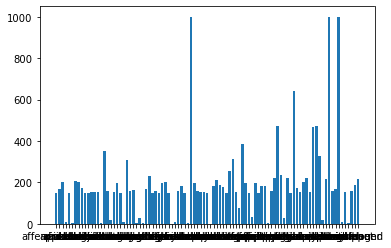

In [5]:
plt.bar(dogs["breed"], height=dogs["count"])
plt.show()

In [6]:
dogs = dogs.sort_values("count", ascending=0)

In [7]:
dogs.head(20)

,breed,count
88,terrier,1000
85,spaniel,1000
42,hound,1000
74,retriever,639
81,setter,471
69,poodle,471
80,schnauzer,466
58,mountain,387
15,bulldog,350
82,sheepdog,328


Consider the first k labels(breeds) with most number of images:


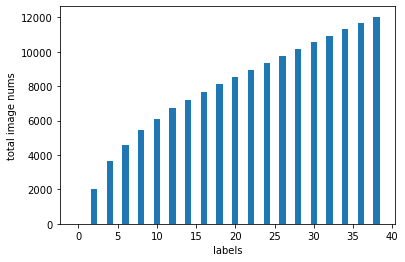

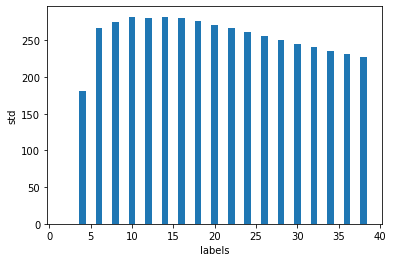

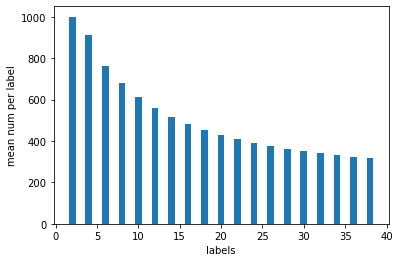

In [8]:
first_x = [*range(0,40,2)]

cummu_sum = [dogs["count"][:x].sum() for x in first_x]
cummu_sd = [dogs["count"][:x].std() for x in first_x]
cummu_mean = [dogs["count"][:x].mean() for x in first_x]

print("Consider the first k labels(breeds) with most number of images:")

fig, ax = plt.subplots()
ax.set_ylabel('total image nums')
ax.set_xlabel('labels')
plt.bar(first_x, cummu_sum)


fig, ax = plt.subplots()
ax.set_ylabel('std')
ax.set_xlabel('labels')
plt.bar(first_x, cummu_sd)

fig, ax = plt.subplots()
ax.set_ylabel('mean num per label')
ax.set_xlabel('labels')
plt.bar(first_x, cummu_mean)


plt.show()